In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import wave

TensorFlow version: 2.6.0


In [3]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd

In [4]:
#importing  libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os


import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
#from include import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
#split the dataset into train and test
X_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_train_mfcc.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_train_mfcc.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_test_mfcc.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_test_mfcc.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4499, 40), (4499, 1), (4233, 41), (4233, 2))

In [6]:
#One hot encode labels

le = LabelEncoder()

def encoding_y(data):
  data = np.array(data['label'])
  data = to_categorical(le.fit_transform(data))
  return data

y_train = encoding_y(y_train)
y_test = encoding_y(y_test) 

In [7]:
X_test = X_test.iloc[:,1:41]
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets
def standardization(data):
  mean = np.mean(data,axis=0)
  std = np.std(data, axis=0)
  data =( data - mean)/std
  data = np.array(data)
  return data

X_train = standardization(X_train)
X_test = standardization(X_test)


In [8]:
model = Sequential()
model.add(layers.Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(750, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              41000     
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              41000     
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4499, 40), (4233, 40), (4499, 10), (4233, 10))

In [11]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 250
num_batch_size = 256
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model_mfc=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
18/18 [==============================] - 1s 34ms/step - loss: 1.7313 - accuracy: 0.4492 - val_loss: 1.8182 - val_accuracy: 0.4085

Epoch 00001: val_loss improved from inf to 1.81816, saving model to .\audio_classification.hdf5
Epoch 2/250
18/18 [==============================] - 0s 21ms/step - loss: 0.9574 - accuracy: 0.6824 - val_loss: 1.7209 - val_accuracy: 0.4888

Epoch 00002: val_loss improved from 1.81816 to 1.72093, saving model to .\audio_classification.hdf5
Epoch 3/250
18/18 [==============================] - 0s 19ms/step - loss: 0.5826 - accuracy: 0.8157 - val_loss: 2.0896 - val_accuracy: 0.4890

Epoch 00003: val_loss did not improve from 1.72093
Epoch 4/250
18/18 [==============================] - 0s 19ms/step - loss: 0.4067 - accuracy: 0.8715 - val_loss: 2.3787 - val_accuracy: 0.4836

Epoch 00004: val_loss did not improve from 1.72093
Epoch 5/250
18/18 [==============================] - 0s 19ms/step - loss: 0.2633 - accuracy: 0.9184 - val_loss: 2.6064 - val_accur

18/18 [==============================] - 0s 20ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 5.3574 - val_accuracy: 0.4833

Epoch 00042: val_loss did not improve from 1.72093
Epoch 43/250
18/18 [==============================] - 0s 23ms/step - loss: 9.9517e-04 - accuracy: 0.9993 - val_loss: 5.3997 - val_accuracy: 0.4845

Epoch 00043: val_loss did not improve from 1.72093
Epoch 44/250
18/18 [==============================] - 0s 20ms/step - loss: 8.8960e-04 - accuracy: 0.9996 - val_loss: 5.4643 - val_accuracy: 0.4845

Epoch 00044: val_loss did not improve from 1.72093
Epoch 45/250
18/18 [==============================] - 0s 19ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 5.4683 - val_accuracy: 0.4852

Epoch 00045: val_loss did not improve from 1.72093
Epoch 46/250
18/18 [==============================] - 0s 19ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 5.5336 - val_accuracy: 0.4841

Epoch 00046: val_loss did not improve from 1.72093
Epoch 47/250
18/18 [==========


Epoch 00083: val_loss did not improve from 1.72093
Epoch 84/250
18/18 [==============================] - 0s 23ms/step - loss: 8.9377e-04 - accuracy: 0.9993 - val_loss: 6.1163 - val_accuracy: 0.4921

Epoch 00084: val_loss did not improve from 1.72093
Epoch 85/250
18/18 [==============================] - 0s 25ms/step - loss: 7.3284e-04 - accuracy: 0.9993 - val_loss: 6.1384 - val_accuracy: 0.4947

Epoch 00085: val_loss did not improve from 1.72093
Epoch 86/250
18/18 [==============================] - 0s 27ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 6.1728 - val_accuracy: 0.4930

Epoch 00086: val_loss did not improve from 1.72093
Epoch 87/250
18/18 [==============================] - 0s 24ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 6.2404 - val_accuracy: 0.4871

Epoch 00087: val_loss did not improve from 1.72093
Epoch 88/250
18/18 [==============================] - 0s 24ms/step - loss: 9.4697e-04 - accuracy: 0.9996 - val_loss: 6.1002 - val_accuracy: 0.4944

Epoch 00088:

18/18 [==============================] - 0s 23ms/step - loss: 6.5885e-04 - accuracy: 0.9993 - val_loss: 6.7534 - val_accuracy: 0.4966

Epoch 00125: val_loss did not improve from 1.72093
Epoch 126/250
18/18 [==============================] - 0s 26ms/step - loss: 6.5927e-04 - accuracy: 0.9993 - val_loss: 6.7597 - val_accuracy: 0.4978

Epoch 00126: val_loss did not improve from 1.72093
Epoch 127/250
18/18 [==============================] - 0s 27ms/step - loss: 7.1581e-04 - accuracy: 0.9993 - val_loss: 6.8158 - val_accuracy: 0.4954

Epoch 00127: val_loss did not improve from 1.72093
Epoch 128/250
18/18 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 6.8502 - val_accuracy: 0.4824

Epoch 00128: val_loss did not improve from 1.72093
Epoch 129/250
18/18 [==============================] - 0s 24ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 6.6566 - val_accuracy: 0.4942

Epoch 00129: val_loss did not improve from 1.72093
Epoch 130/250
18/18 [=

18/18 [==============================] - 0s 24ms/step - loss: 0.1655 - accuracy: 0.9491 - val_loss: 3.0603 - val_accuracy: 0.5105

Epoch 00166: val_loss did not improve from 1.72093
Epoch 167/250
18/18 [==============================] - 1s 32ms/step - loss: 0.0983 - accuracy: 0.9675 - val_loss: 3.5365 - val_accuracy: 0.4911

Epoch 00167: val_loss did not improve from 1.72093
Epoch 168/250
18/18 [==============================] - 0s 24ms/step - loss: 0.0538 - accuracy: 0.9816 - val_loss: 3.9776 - val_accuracy: 0.5086

Epoch 00168: val_loss did not improve from 1.72093
Epoch 169/250
18/18 [==============================] - 0s 25ms/step - loss: 0.0300 - accuracy: 0.9920 - val_loss: 4.1431 - val_accuracy: 0.5086

Epoch 00169: val_loss did not improve from 1.72093
Epoch 170/250
18/18 [==============================] - 0s 24ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 4.6458 - val_accuracy: 0.4914

Epoch 00170: val_loss did not improve from 1.72093
Epoch 171/250
18/18 [=============

18/18 [==============================] - 1s 29ms/step - loss: 0.0013 - accuracy: 0.9991 - val_loss: 6.6694 - val_accuracy: 0.5027

Epoch 00208: val_loss did not improve from 1.72093
Epoch 209/250
18/18 [==============================] - 1s 28ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 6.6092 - val_accuracy: 0.5074

Epoch 00209: val_loss did not improve from 1.72093
Epoch 210/250
18/18 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.9991 - val_loss: 6.6480 - val_accuracy: 0.5070

Epoch 00210: val_loss did not improve from 1.72093
Epoch 211/250
18/18 [==============================] - 1s 31ms/step - loss: 9.6163e-04 - accuracy: 0.9991 - val_loss: 6.6677 - val_accuracy: 0.5074

Epoch 00211: val_loss did not improve from 1.72093
Epoch 212/250
18/18 [==============================] - 1s 29ms/step - loss: 0.0013 - accuracy: 0.9989 - val_loss: 6.6954 - val_accuracy: 0.5044

Epoch 00212: val_loss did not improve from 1.72093
Epoch 213/250
18/18 [=========

18/18 [==============================] - 1s 31ms/step - loss: 8.4319e-04 - accuracy: 0.9996 - val_loss: 7.4997 - val_accuracy: 0.5006

Epoch 00249: val_loss did not improve from 1.72093
Epoch 250/250
18/18 [==============================] - 1s 32ms/step - loss: 9.4514e-04 - accuracy: 0.9993 - val_loss: 7.5005 - val_accuracy: 0.5020

Epoch 00250: val_loss did not improve from 1.72093
Training completed in time:  0:01:51.765642


In [13]:
# Evaluating the model on the training and testing set

score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9995554685592651
Testing Accuracy:  0.5020080208778381


In [14]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5020080208778381


In [15]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[3 2 2 ... 9 1 1]


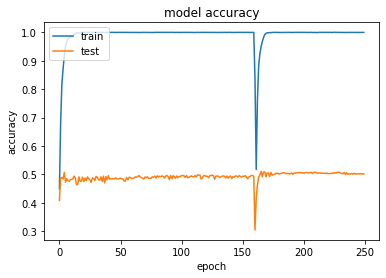

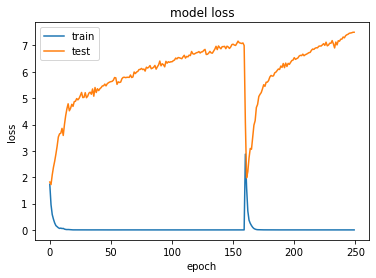

In [16]:
# summarize history for accuracy
plt.plot(model_mfc.history['accuracy'])
plt.plot(model_mfc.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_mfc.history['loss'])
plt.plot(model_mfc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
train_hist = pd.DataFrame(model_mfc.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,1.731283,0.449211,1.818160,0.408457
1,0.957381,0.682374,1.720932,0.488779
2,0.582580,0.815737,2.089634,0.489015
3,0.406667,0.871527,2.378703,0.483581
4,0.263321,0.918426,2.606397,0.506969
...,...,...,...,...
245,0.000736,0.999555,7.461534,0.501772
246,0.000782,0.999555,7.472339,0.502244
247,0.001168,0.999555,7.480918,0.502244
248,0.000843,0.999555,7.499722,0.500591


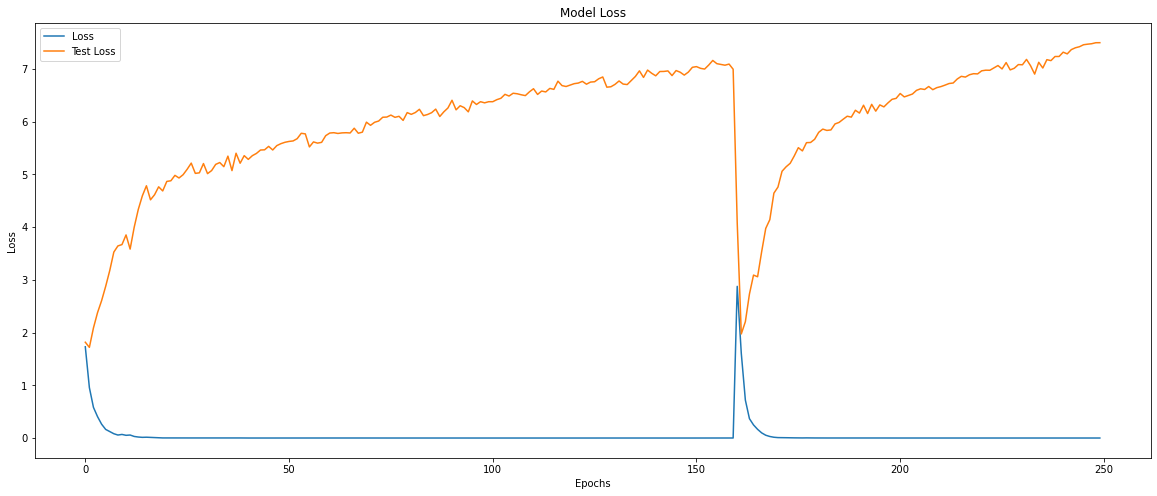

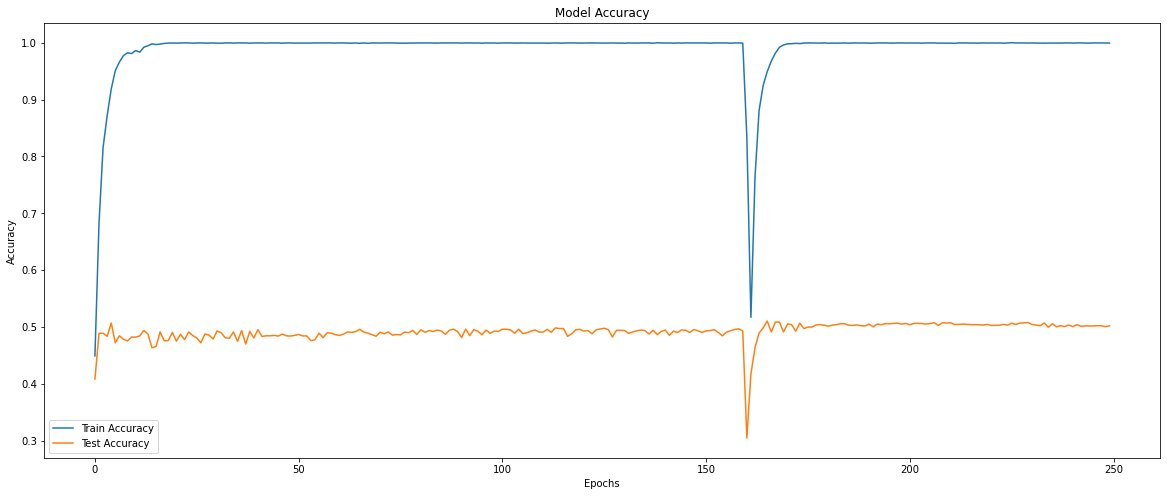

In [18]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['Loss','Test Loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [19]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[114  11  75  32  18  65   9  16  16 144]
 [  2 166   2   3   1   8   0   3   2  34]
 [  6   1 275  74   5  15  13   6  43  62]
 [ 15   4  32 345   9  22  15   4  25  29]
 [  6  12  33  45 169  17  11  39  28 140]
 [ 23   4  51  58   8 229   3  31  17  59]
 [  1   0  19  40   3   3 112   0   3   3]
 [ 29   4  13  21 115  83   8 109   2  68]
 [  4   5   3  75   9  24   4   0 253  16]
 [ 12   9  26  29  29   8   8   9  17 353]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.54      0.23      0.32       500
           1       0.77      0.75      0.76       221
           2       0.52      0.55      0.53       500
           3       0.48      0.69      0.56       500
           4       0.46      0.34      0.39       500
           5       0.48      0.47      0.48       483
           6       0.61      0.61      0.61       184
           7       0.50      0.24      0.33       452
           8       0.62      0.